# Auto Loan Credit Decision Analysis

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import HTML
display(HTML('''<style>
    div.text_cell_render {
        font-size: 11pt;
        line-height: 1.2;
    }
</style>'''))

In [71]:
auto_data = pd.read_csv("C:/Users/david/Downloads/Training Dataset A_R-384922_Candidate Attach #1_PresSE_SRF #1141.csv")

## Exploratory Data Analysis

In [73]:
auto_data.shape

(21606, 43)

The training dataset consist of 21606 individuals who applied for an auto loan. We have various credit and financial related variables for each applicant, as well as gender and race, for a total of 41 features. Our primary variable of interest is whether the applicant was approved for the loan ('aprv_flag'), and we will try to model this using the aforementioned features. We have a secondary evaluation variable 'bad_flag' which indicates loan performance in the most recent 12 months. In this report we will first perform some exploratory analysis on the data, fit several models following appropriate data pre-processing, examine the models' performance, and finally interpret results and use the models to answer several business questions.

In [74]:
approval_rate = auto_data['aprv_flag'].mean()
bad_flag_approval = auto_data[auto_data['aprv_flag'] == 1]['bad_flag'].mean()

print("approval rate: ", approval_rate, "\nbad flag approval rate: ", bad_flag_approval)

approval rate:  0.7383134314542257 
bad flag approval rate:  0.025328448711470438


Roughly 74% of applicants were approved for an auto loan. Of these approved loans, 2.5% saw poor performance in some way.

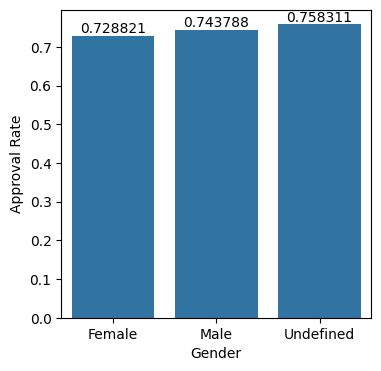

In [106]:
gender_approval = auto_data.groupby('Gender')['aprv_flag'].agg('mean')

plt.figure(figsize=(4, 4))

ax = sns.barplot(pd.DataFrame(data = gender_approval), x = 'Gender', y = 'aprv_flag')
ax.bar_label(ax.containers[0])
ax.set_ylabel('Approval Rate')
plt.show()

Males saw slightly higher approval rates than females. A minority of applicants do not have a recorded gender ('Undefined').

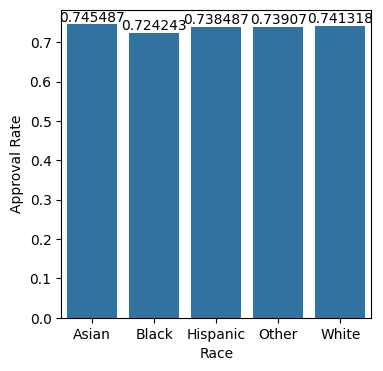

In [122]:
racial_approval = auto_data.groupby('Race')['aprv_flag'].agg('mean')

plt.figure(figsize=(4, 4))

ax = sns.barplot(pd.DataFrame(data = racial_approval), x = 'Race', y = 'aprv_flag')
ax.bar_label(ax.containers[0])
ax.set_ylabel('Approval Rate')
plt.show()

Black applicants had the lowest approval rate of all races.

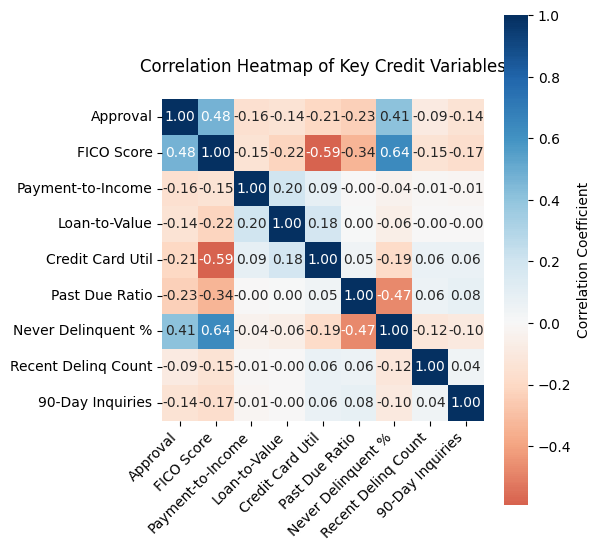

In [77]:
readable_names = {
    'aprv_flag': 'Approval',
    'fico': 'FICO Score',
    'pti_1req': 'Payment-to-Income',
    'ltv_1req': 'Loan-to-Value',
    'p12_bcx7110_a': 'Credit Card Util',
    'p12_all7170_a': 'Past Due Ratio',
    'p12_all7937_a': 'Never Delinquent %',
    'p12_all2427_a': 'Recent Delinq Count',
    'clact9428_a': '90-Day Inquiries'
}

key_vars = list(readable_names.keys())

corr_matrix = auto_data[key_vars].corr()

corr_matrix.index = [readable_names[col] for col in corr_matrix.index]
corr_matrix.columns = [readable_names[col] for col in corr_matrix.columns]

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, 
            annot=True,           # Show correlation values
            cmap='RdBu',         # Red-Blue color scheme
            center=0,            # Center the colormap at 0
            fmt='.2f',          # Show 2 decimal places
            square=True,        # Make cells square
            cbar_kws={'label': 'Correlation Coefficient'})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Optional: Add title
plt.title('Correlation Heatmap of Key Credit Variables', pad=20)

plt.show()

FICO and other credit indicators correlate with loan approval. Some of these variables correlate with one another, so we will consider some appropriate preprocessing steps later.

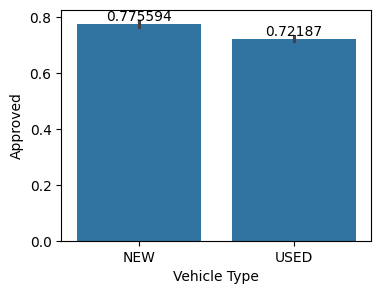

In [121]:
plt.figure(figsize=(4, 3))

ax = sns.barplot(data=auto_data, x='collateral_dlrinput_newused_1req', y='aprv_flag')

ax.bar_label(ax.containers[0])
ax.set_xlabel('Vehicle Type')
ax.set_ylabel('Approved')
plt.show()

Loans for new cars were approved at a slightly higer rate than for used cars.

In [125]:
na_pct = auto_data.isnull().mean().sort_values(ascending=False)
pd.DataFrame({'Missing Rate': na_pct}).reset_index().rename(columns={'index': 'Feature'}).head(10)

,Feature,Missing Rate
0,cloil0214_a,0.996390
1,clall2434_a,0.966722
2,cltra4405_a,0.963575
3,clall5010_a,0.889383
4,p12_aua8151_a,0.824493
5,clact9428_a,0.585671
6,clact9429_a,0.585671
7,clntr9437_a,0.585671
8,p12_all8150_a,0.573868
9,p12_aut7110_a,0.487642


While demographic variables like race and gender, and some features have zero or very low amounts of 'na' values, several features have extremely high rates of 'na' values. 'cloil0214_a', 'clall2434_a', and 'cltra4405_a', all of which relate to the applicant's credit behavior, consist of greater than 95% 'na' values. 

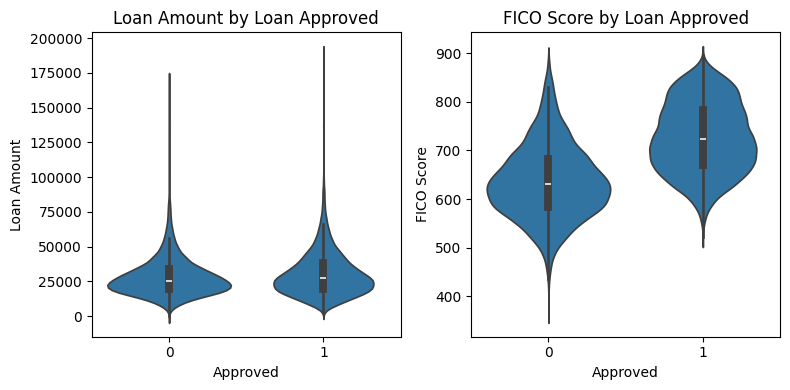

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.ravel()

for i, col in enumerate(['amtfinanced_1req', 'fico']):
    col_name = {'amtfinanced_1req': 'Loan Amount', 'fico': 'FICO Score'}
    ax = sns.violinplot(data = auto_data, x = 'aprv_flag', y = col, ax = axes[i])
    axes[i].set_title(f'{col_name[col]} by Loan Approved')
    ax.set_ylabel(col_name[col])
    ax.set_xlabel('Approved')

plt.tight_layout()
plt.show()

Plotting some key financial indicators against loan approval provides insight into how these variables might affect the likelihood someone is approved for an auto loan. Applicants that are approved do tend to have higher FICO scores, which is intuitive, however it is difficult to interpret the same plot for the amount financed in the loan. Many financial variables tend to have high outliers or possible data errors relating to income, debt, and loan amounts. 

## Data Preprocessing

In [80]:
#creating copied dataset for preprocessing
#dropping columns with more than 60% na rates

auto_data_processed = auto_data.copy()
na_rates = auto_data_processed.isna().mean()
high_na_vars = na_rates[na_rates > .6].index
auto_data_processed = auto_data_processed.drop(columns = high_na_vars)

First we eliminate variables with more than 60% of their values missing.

In [118]:
print("Number of mostly missing variables:", len(high_na_vars))

Number of mostly missing variables: 5


This removes 5 variables.

In [82]:
#could reduce fair lending opportunities

auto_data_processed = auto_data_processed.drop(columns = ['Race', 'Gender', 'bad_flag'])
numeric_cols_processed = auto_data_processed.select_dtypes(include=[np.number]).columns

Next we drop the race and gender columns since these reduce fair lending opportunities. 'bad_flag' could result in data leakage so we remove it as well. 

In [83]:
#capping columns at 99th percentile

def capCols(df, cols):
    for col in cols:
        if df[col].dtype.kind in 'biufc':
            prcntle_99 = df[col].quantile(.99)
            df[col] = df[col].clip(upper = prcntle_99)

capCols(auto_data_processed, numeric_cols_processed)

Since our data has some high outliers, we cap it at 99%. This reduces the outsized effect that certain values could have on our model.

In [84]:
feature_num_cols = numeric_cols_processed.drop('aprv_flag')

In [85]:
#impute na values with columns median

def imputeNAs(df, cols):
    for col in cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median())

imputeNAs(auto_data_processed, feature_num_cols)

With the remaining columns, we fill in missing values with the median value in that column.

In [86]:
#transform features with log skew > 1.5 and >1.2x times greater correlation with log odds for log transformed compared to original feature

info = []
columns_to_transform = []

for col in feature_num_cols:
   try:
       #calculate skewness
       log_skew = np.log1p(auto_data_processed[col]).skew()
       orig_skew = auto_data_processed[col].skew()

       #calculate correlations
       deciles = pd.qcut(auto_data_processed[col], q=10, duplicates='drop')
       mean_target = auto_data_processed.groupby(deciles, observed = True)['aprv_flag'].mean().reset_index()
       
       if len(mean_target) >= 2:
           mean_target['decile_mid'] = mean_target[deciles.name].map(lambda x: x.mid)
           epsilon = 1e-10
           mean_target['log_odds'] = np.log((mean_target['aprv_flag'] + epsilon) / (1 - mean_target['aprv_flag'] + epsilon))
           corr_original = abs(stats.pearsonr(mean_target['decile_mid'], mean_target['log_odds'])[0])
       else:
           corr_original = 0

       log_deciles = pd.qcut(np.log1p(auto_data_processed[col]), q=10, duplicates='drop')
       log_mean_target = auto_data_processed.groupby(log_deciles, observed = True)['aprv_flag'].mean().reset_index()
       
       if len(log_mean_target) >= 2:
           log_mean_target['decile_mid'] = log_mean_target[log_deciles.name].map(lambda x: x.mid)
           log_mean_target['log_odds'] = np.log((log_mean_target['aprv_flag'] + epsilon) / (1 - log_mean_target['aprv_flag'] + epsilon))
           log_corr = abs(stats.pearsonr(log_mean_target['decile_mid'], log_mean_target['log_odds'])[0])
       else:
           log_corr = 0
           
       #decision criteria
       if (orig_skew > 1.5) and (abs(log_corr) > abs(corr_original) * 1.2):
           columns_to_transform.append(col)
           
       info.append({
           'feature': col,
           'original_skewness': orig_skew,
           'log_skewness': log_skew,
           'original_corr': corr_original,
           'log_corr': log_corr,
           'transform': col in columns_to_transform
       })
       
   except Exception as e:
       print(f"Error processing {col}: {str(e)}")
       continue

#transform selected columns
for col in columns_to_transform:
   auto_data_processed[col] = np.log1p(auto_data_processed[col])

info_df = pd.DataFrame(info)
print(f"Transformed {len(columns_to_transform)} columns: {columns_to_transform}")

Transformed 4 columns: ['p12_bcc8120_a', 'p12_rev1300_a', 'p12_aua0300_a', 'p12_bcc3456_a']


Since our logistic regression model assumes linearity between the features and logit of the response, we transform four variables that are heavily right skewed. We choose these four based on them having a log skewness greater than 1.5 and having a 1.2x greater correlation with the approval flag after being transformed.

In [87]:
#one hot encode categorical columns

#bad flag already 1/0, aprv flag response
exclude_cols = ['aprv_flag']
feature_names = [col for col in auto_data_processed.columns if col not in exclude_cols]

categorical_cols = ['collateral_dlrinput_newused_1req']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
categorical_encoded = encoder.fit_transform(auto_data_processed[categorical_cols])

encoded_feature_names = []
for i, col in enumerate(categorical_cols):
    #get all categories except the dropped one (first category)
    categories = encoder.categories_[i][1:]
    #create feature names
    encoded_feature_names.extend([f"{col}_{cat}" for cat in categories])

We also encode our only categorical column remaining: whether the car is new or used.

In [88]:
#create X matrix with all processed features

numeric_feature_names = [col for col in feature_names if col not in categorical_cols]
X_numeric = auto_data_processed[numeric_feature_names].values
X = np.hstack([X_numeric, categorical_encoded])
x_feature_names = numeric_feature_names + encoded_feature_names

In [89]:
#remove highly correlated features

def removeCorrelatedVars(x, features, vif_thresh, corr_thresh):
    df = pd.DataFrame(x, columns=features)
    selected_features = features.copy()
    #iteratively remove features until none with vif above 5 remain
    kept_features = encoded_feature_names + ['fico', 'amtfinanced_1req', 'ltv_1req', 'pti_1req']
    while True:
        vif_data = []
        for i in range(len(selected_features)):
            #don't want to remove key business features, but still have to consider their correlations with other featuers
            if selected_features[i] in kept_features:
                continue
            vif = variance_inflation_factor(df[selected_features].values, i)
            vif_data.append({'feature': selected_features[i], 'vif': vif})
            vif_df = pd.DataFrame(vif_data).sort_values('vif', ascending = False)
        if vif_df['vif'].max() < vif_thresh:
            break
        removed_feature = vif_df.iloc[0]['feature']
        selected_features.remove(removed_feature)
        print(f"Removed {removed_feature} (VIF: {vif_df.iloc[0]['vif']:.2f})")

    #iterate through pairs of remaining features, getting rid of one in each pair if the pair's correlation > .7
    corr_matrix = df[selected_features].corr()
    for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > corr_thresh:
                    #remove feature with higher mean absolute correlation
                    feat1, feat2 = corr_matrix.columns[i], corr_matrix.columns[j]
                    feat1_mean_corr = abs(corr_matrix[feat1]).mean()
                    feat2_mean_corr = abs(corr_matrix[feat2]).mean()
                
                    if feat1_mean_corr > feat2_mean_corr:
                        if feat1 in selected_features:
                            selected_features.remove(feat1)
                            print(f"Removed {feat1} (high correlation with {feat2})")
                    else:
                        if feat2 in selected_features:
                            selected_features.remove(feat2)
                            print(f"Removed {feat2} (high correlation with {feat1})")
    return selected_features, df[selected_features].values

#run on numeric features
selected_features, df_selected = removeCorrelatedVars(X, x_feature_names, 5, .7)

Removed p12_all7937_a (VIF: 87.84)
Removed p12_all7938_a (VIF: 33.09)
Removed p12_rev1300_a (VIF: 21.89)
Removed p12_aut7110_a (VIF: 16.96)
Removed p12_bcc8120_a (VIF: 14.16)
Removed p12_iln8220_a (VIF: 11.12)
Removed clact9429_a (VIF: 11.11)
Removed p12_reh7120_a (VIF: 10.69)
Removed p12_all7120_a (VIF: 10.00)
Removed p12_all8370_a (VIF: 9.32)
Removed p12_aua8220_a (VIF: 8.06)
Removed p12_aua0300_a (VIF: 5.52)


Finally, we remove 12 variables that are correlated with other variables. While some of these would seem helpful in the model, much of their information is already contained within other variables we keep, like FICO.

In [90]:
auto_data_test = pd.read_csv("C:/Users/david/Downloads/Evaluation Dataset B_R-384922_Candidate Attach #2_PresSE_SRF #1141.csv")

In [91]:
#only keep columns use in training

auto_data_test_x = auto_data_test.copy()
auto_data_test_x = auto_data_test_x.drop(columns = high_na_vars)

In [92]:
#preprocessing test dataset for evaluation--setting same 99%tile caps

capCols(auto_data_test_x, auto_data_test_x.columns)

In [93]:
#impute missing values with medians

imputeNAs(auto_data_test_x, auto_data_test_x.columns)

In [94]:
#apply transformations on same columns

for col in columns_to_transform:
    auto_data_test_x[col] = np.log1p(auto_data_test_x[col])

In [95]:
#one hot encode categorical columns

categorical_encoded_test = encoder.fit_transform(auto_data_test_x[categorical_cols])
X_numeric_test = auto_data_test_x[numeric_feature_names].values
X_test = np.hstack([X_numeric_test, categorical_encoded_test])
auto_data_test_x = pd.DataFrame(X_test, columns = x_feature_names)

In [96]:
#remove same highly correlated columns

drop_cols = [col for col in auto_data_test_x.columns if col not in selected_features]
auto_data_test_x = auto_data_test_x.drop(columns = drop_cols)

In order to evaluate our model on the test data set of ~5400 records, we apply the same preprocessing steps on its columns.

## Logistic Regression Model

In [127]:
#function to run and evaluate model on both datasets

def evaluate_model(x_train, y_train, x_test, y_test):
    model = LogisticRegression(solver='liblinear', penalty='l1', C=1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    #store metrics on test dataset

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)}
    
    #store coefficients and odds ratios

    coef_df = pd.DataFrame({
    'Feature': auto_data_test_x.columns,
    'Coefficient': model.coef_[0],
    'Odds_Ratio': np.exp(model.coef_[0])
})
    
    coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])

    coef_df_sorted = coef_df.sort_values('Abs_Coefficient', ascending=False)

    return metrics, coef_df_sorted, y_pred
    
lr_metrics, coeffs, y_pred_lr = evaluate_model(df_selected, auto_data_processed['aprv_flag'], auto_data_test_x.values, auto_data_test['aprv_flag'])

In [128]:
print(pd.DataFrame([lr_metrics]))

   accuracy  precision    recall        f1
0  0.811852   0.839854  0.922078  0.879048


Our logistic regression model correctly predicts if an applicant will be approved for an auto loan 81% of the time. Among those applicants our model predicts will be approved for a loan, 84% were actually approved. Our model also correctly identifies 92% of those actually approved. The F1 score, a common metric for binary classification tasks, is 88%.

In [120]:
coeffs

,Feature,Coefficient,Odds_Ratio,Abs_Coefficient
13,p12_bcc3456_a,-0.376206,0.686461,0.376206
2,pti_1req,-0.087519,0.916201,0.087519
16,p12_all2427_a,-0.070588,0.931846,0.070588
19,clntr9437_a,-0.065797,0.936321,0.065797
20,clact9428_a,-0.043979,0.956974,0.043979
21,collateral_dlrinput_newused_1req_USED,-0.025245,0.975071,0.025245
0,fico,0.015961,1.016089,0.015961
14,p12_als1300_a,0.015613,1.015735,0.015613
9,p12_all7517_a,-0.012759,0.987322,0.012759
3,ltv_1req,-0.009248,0.990795,0.009248


Payment-to-income ratio and loan-to-value ratio inversely relate to loan approval, while higher FICO scores tend to result in higher likelihoods of approval. Other indicators relating to frequency or general goodness of credit behavior are also useful predictors. A wide range in the scales and units of variables makes comparing individual coefficients difficult.

## XGBoost Model

In [115]:
#only need to drop certain columns, no transformations or collinearity checks necessary

def prepareXGBdata(df):
    drop_cols = list(high_na_vars) + ['Race', 'Gender', 'aprv_flag', 'bad_flag']
    df = df.drop(columns = drop_cols)
    df['collateral_dlrinput_newused_1req'] = np.where(df['collateral_dlrinput_newused_1req'] == 'NEW', 0, 1)
    return df

xgb_x_train = prepareXGBdata(auto_data.copy())
xgb_x_test = prepareXGBdata(auto_data_test.copy())

xgb_y_train = auto_data['aprv_flag']
xgb_y_test = auto_data_test['aprv_flag']

Since the XGBoost model can handle missing data and doesn't assume linear relationships or the absence of collinearity, we only drop columns with mostly missing (>60%) values before fitting the model. 

In [101]:
#run and evaluate xgboost model

def runXGboost(x_train, y_train, x_test, y_test):
    xgb_model = XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=4,
        random_state=42
    )

    xgb_model.fit(x_train, y_train)
    y_pred = xgb_model.predict(x_test)

    #store metrics on test data

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    importance_df = pd.DataFrame({
        'Feature': x_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return metrics, importance_df, xgb_model, y_pred

In [102]:
xgb_metrics, feature_imp, xgb_model, y_pred_xgb = runXGboost(xgb_x_train, xgb_y_train, xgb_x_test, xgb_y_test)
print(pd.DataFrame([xgb_metrics]))

   accuracy  precision    recall        f1
0  0.861667   0.875663  0.948052  0.910421


Our XGBoost model performs marginally better than the logistic regresion model in all four key metrics. It correctly predicts the approval decision for 86% of applicants, and is aligned with the actual approved applicants 95% of the time.

In [103]:
print("\nTop 5 Important Features:")
print(feature_imp.head(5))


Top 5 Important Features:
          Feature  Importance
0            fico    0.272728
16  p12_all7517_a    0.064204
24  p12_all8370_a    0.054537
3        pti_1req    0.051841
32    clact9429_a    0.046714


While the XGBoost model also relies heavily on features related to credit behavior, FICO is clearly the most important feature. This makes sense since an applicant's credit score is quite literally intended to indicate if they could be trusted to pay back their loan on schedule.

## Model Comparison

Our two models present a clear tradeoff: the logistic regression model is easily interpretable, allowing us to predict the effect that a change in a variable like FICO, or LTV, would have on the applicant's likelihood of being approved for a loan. On the other hand, the XGBoost model performs slightly better on the approval flag, but is less straightforward to interpret. While we can see which features are more important within the model, we do not have a way to directly tie them to the model's output. 

In [136]:
def plot_performance_matrix(y_pred, bad_flag, model):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    perf_matrix = np.zeros((2, 2))
    
    #calculate counts for each combination
    perf_matrix[0,0] = sum((y_pred == 1) & (bad_flag == 1))  # Approved & Bad
    perf_matrix[0,1] = sum((y_pred == 1) & (bad_flag == 0))  # Approved & Good
    perf_matrix[1,0] = sum((y_pred == 0) & (bad_flag == 1))  # Declined & Bad
    perf_matrix[1,1] = sum((y_pred == 0) & (bad_flag == 0))  # Declined & Good
    
    #calculate percentages
    total_approved = sum(y_pred == 1)
    total_declined = sum(y_pred == 0)
    
    perf_matrix_pct = np.zeros((2, 2))
    row_sums = perf_matrix.sum(axis=1)
    for i in range(2):
        perf_matrix_pct[i,:] = (perf_matrix[i,:] / row_sums[i] * 100)

    sns.heatmap(perf_matrix_pct,
                    annot=True,
                    fmt='.1f',
                    cmap='RdYlGn',
                    xticklabels=['Bad', 'Good'],
                    yticklabels=['Approved', 'Declined'],
                    ax=ax)
    ax.set_title(f'Performance Analysis (% within decision): {model}')
    ax.set_xlabel('Actual Performance')
    ax.set_ylabel('Model Decision')
    
    plt.tight_layout()
    plt.show()

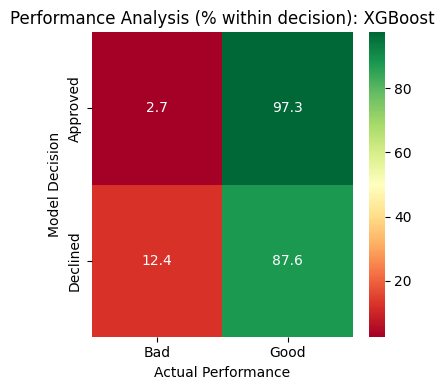

In [137]:
plot_performance_matrix(y_pred_xgb, auto_data_test['bad_flag'], 'XGBoost')

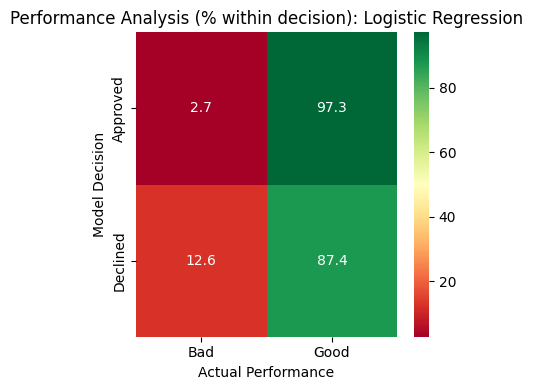

In [138]:
plot_performance_matrix(y_pred_lr, auto_data_test['bad_flag'], 'Logistic Regression')

In [142]:
print("XGBoost model approval rate: ", y_pred_xgb.mean())

XGBoost model approval rate:  0.8027777777777778


In [143]:
print("Logistic Regression model approval rate: ", y_pred_lr.mean())

Logistic Regression model approval rate:  0.8140740740740741


Although the XGBoost model performs better on the approval flag test, the two models are equally good at identifying applicants that do not default and pay on schedule using 'bad_flag' in the test dataset. As a result, the improved transparency and interpretability of the logistic regression model makes it a better choice for adaptation. In addition, the logistic regression model approves a higher proportion of applicants, so it identifies a greater number of applicants unlikely to default and with good credit quality.

Our chosen logistic regression model is fairly conservative; while 97% of approvals it makes perform well based on the 'bad_flag' indicator, so do almost 88% of applicants it does not approve. Given the cost to the business of approving loans that are poor performing, this makes sense, although it could be worth looking into changing thresholds in the model to affect how many loans are approved.

## Business Questions

### Model Interpretation

Our model relies on a variety of variables, including those relating to credit behavior, trade history, and other financial indicators. In addition, we avoid using any variables relating to the applicant's age, gender, race, or other demographics. Since many of our variables only consider the applicant's recent credit and trade history, an applicant that is rejected for a loan but applies for the same loan in a year could be approved if their financial behavior undergoes significant change.

### Approval by Gender

In [139]:
gender_aprv = pd.DataFrame({'Gender': auto_data_test['Gender'], 'Model_Aprv': y_pred_lr, 'True_Aprv': auto_data_test['aprv_flag']})
gender_aprv.groupby(['Gender']).mean()

,Model_Aprv,True_Aprv
Gender,,
Female,0.818783,0.737654
Male,0.814480,0.749739
Undefined,0.768340,0.683398


Females and males are approved at nearly the exact same rate by our model.

### Improvement Areas

Additional data on the vehicle and the applicant's income and/or employment data could be useful in incorporating additional ways to determine whether an applicant should be approved for an auto loan.